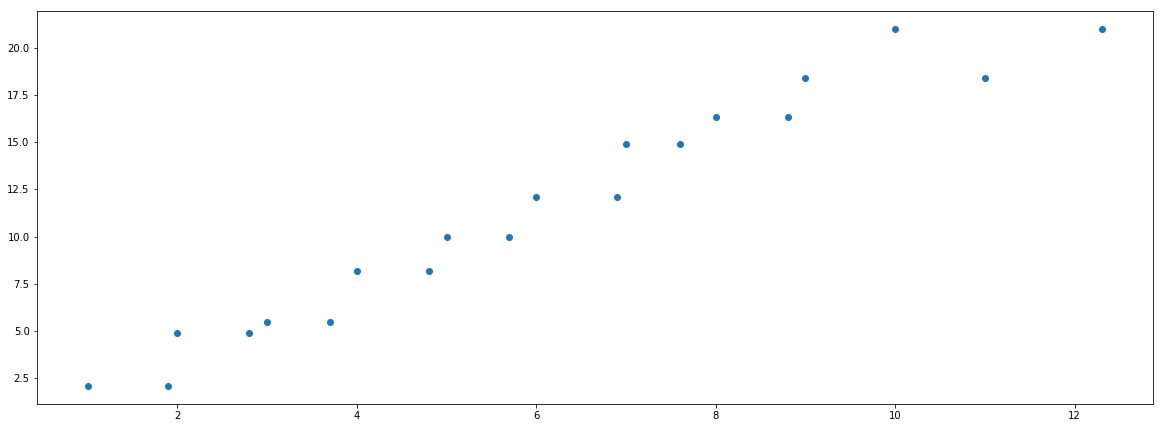

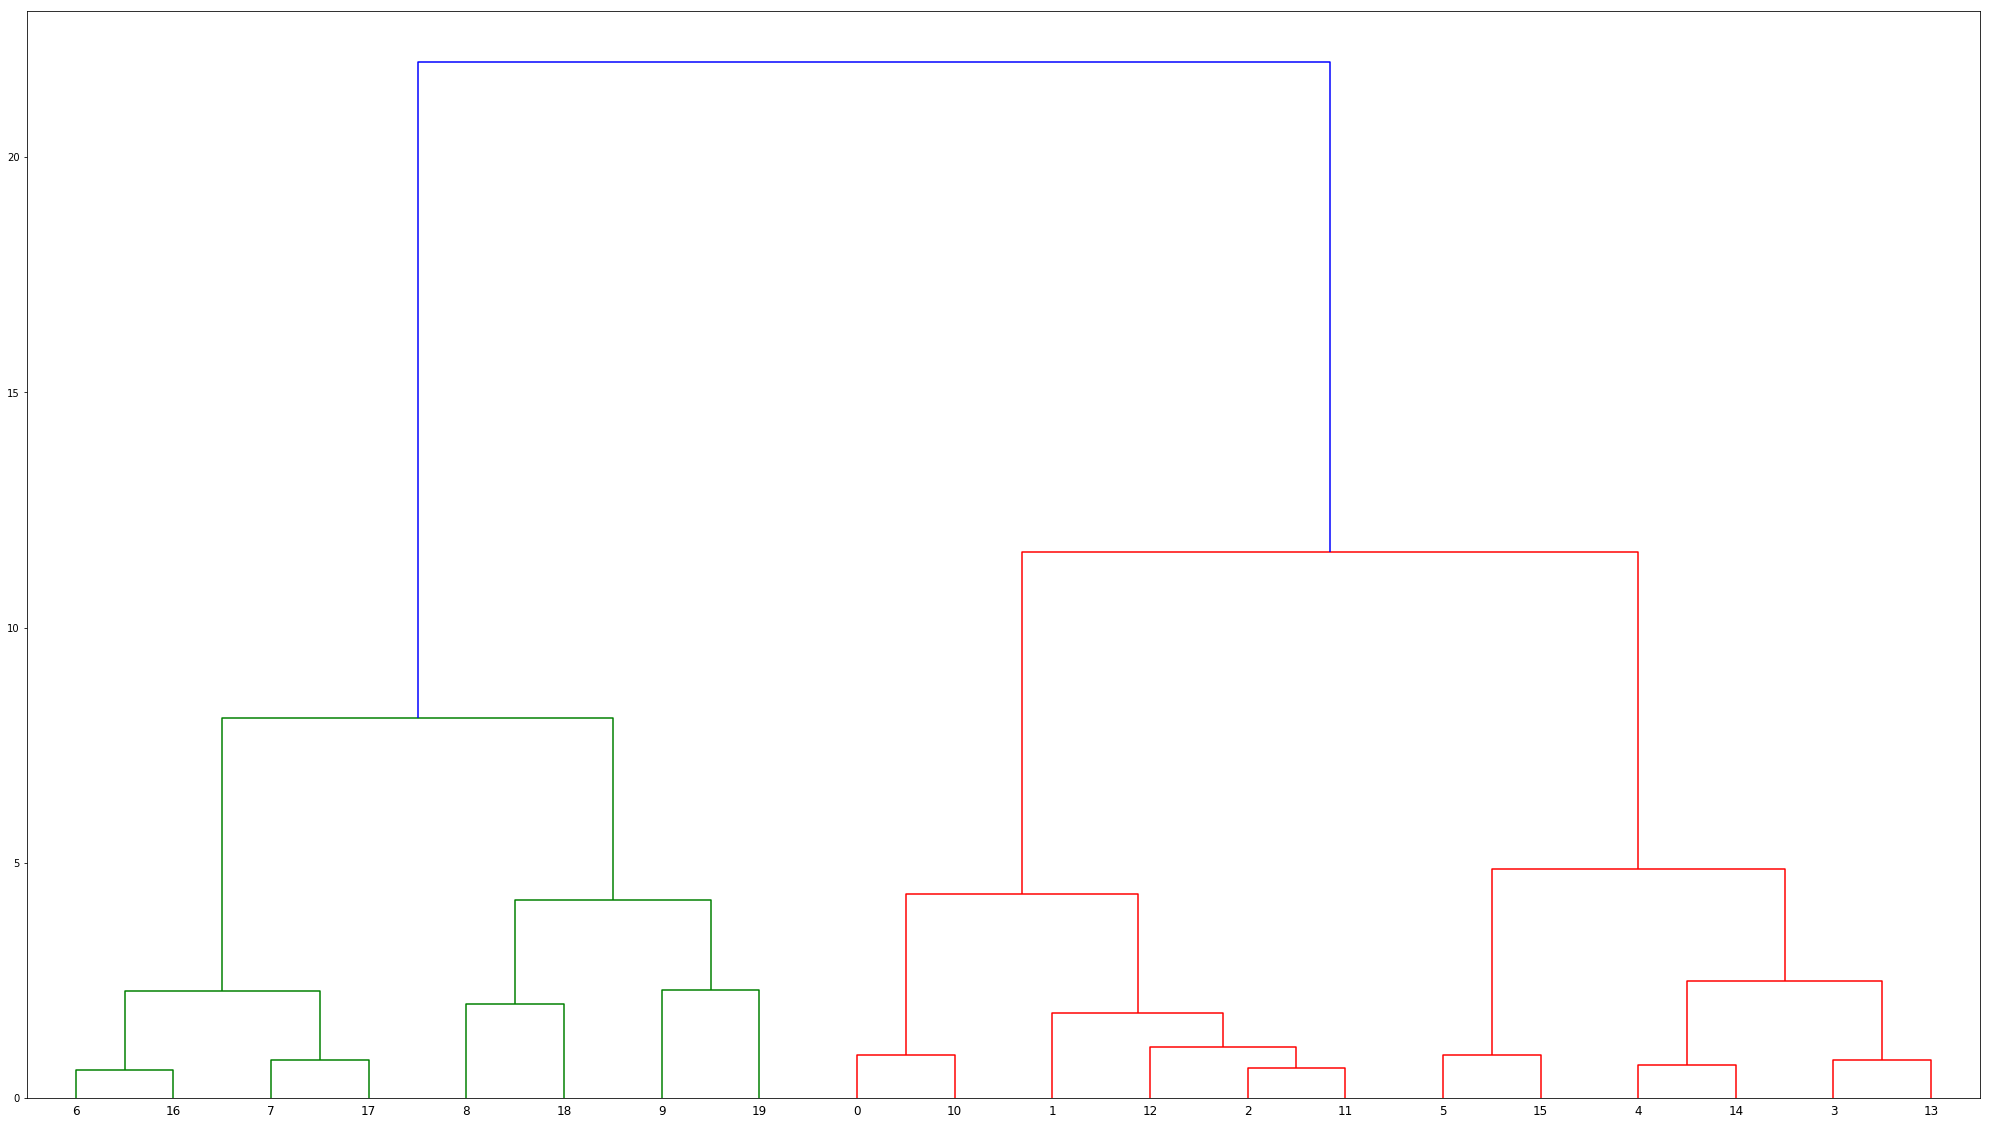

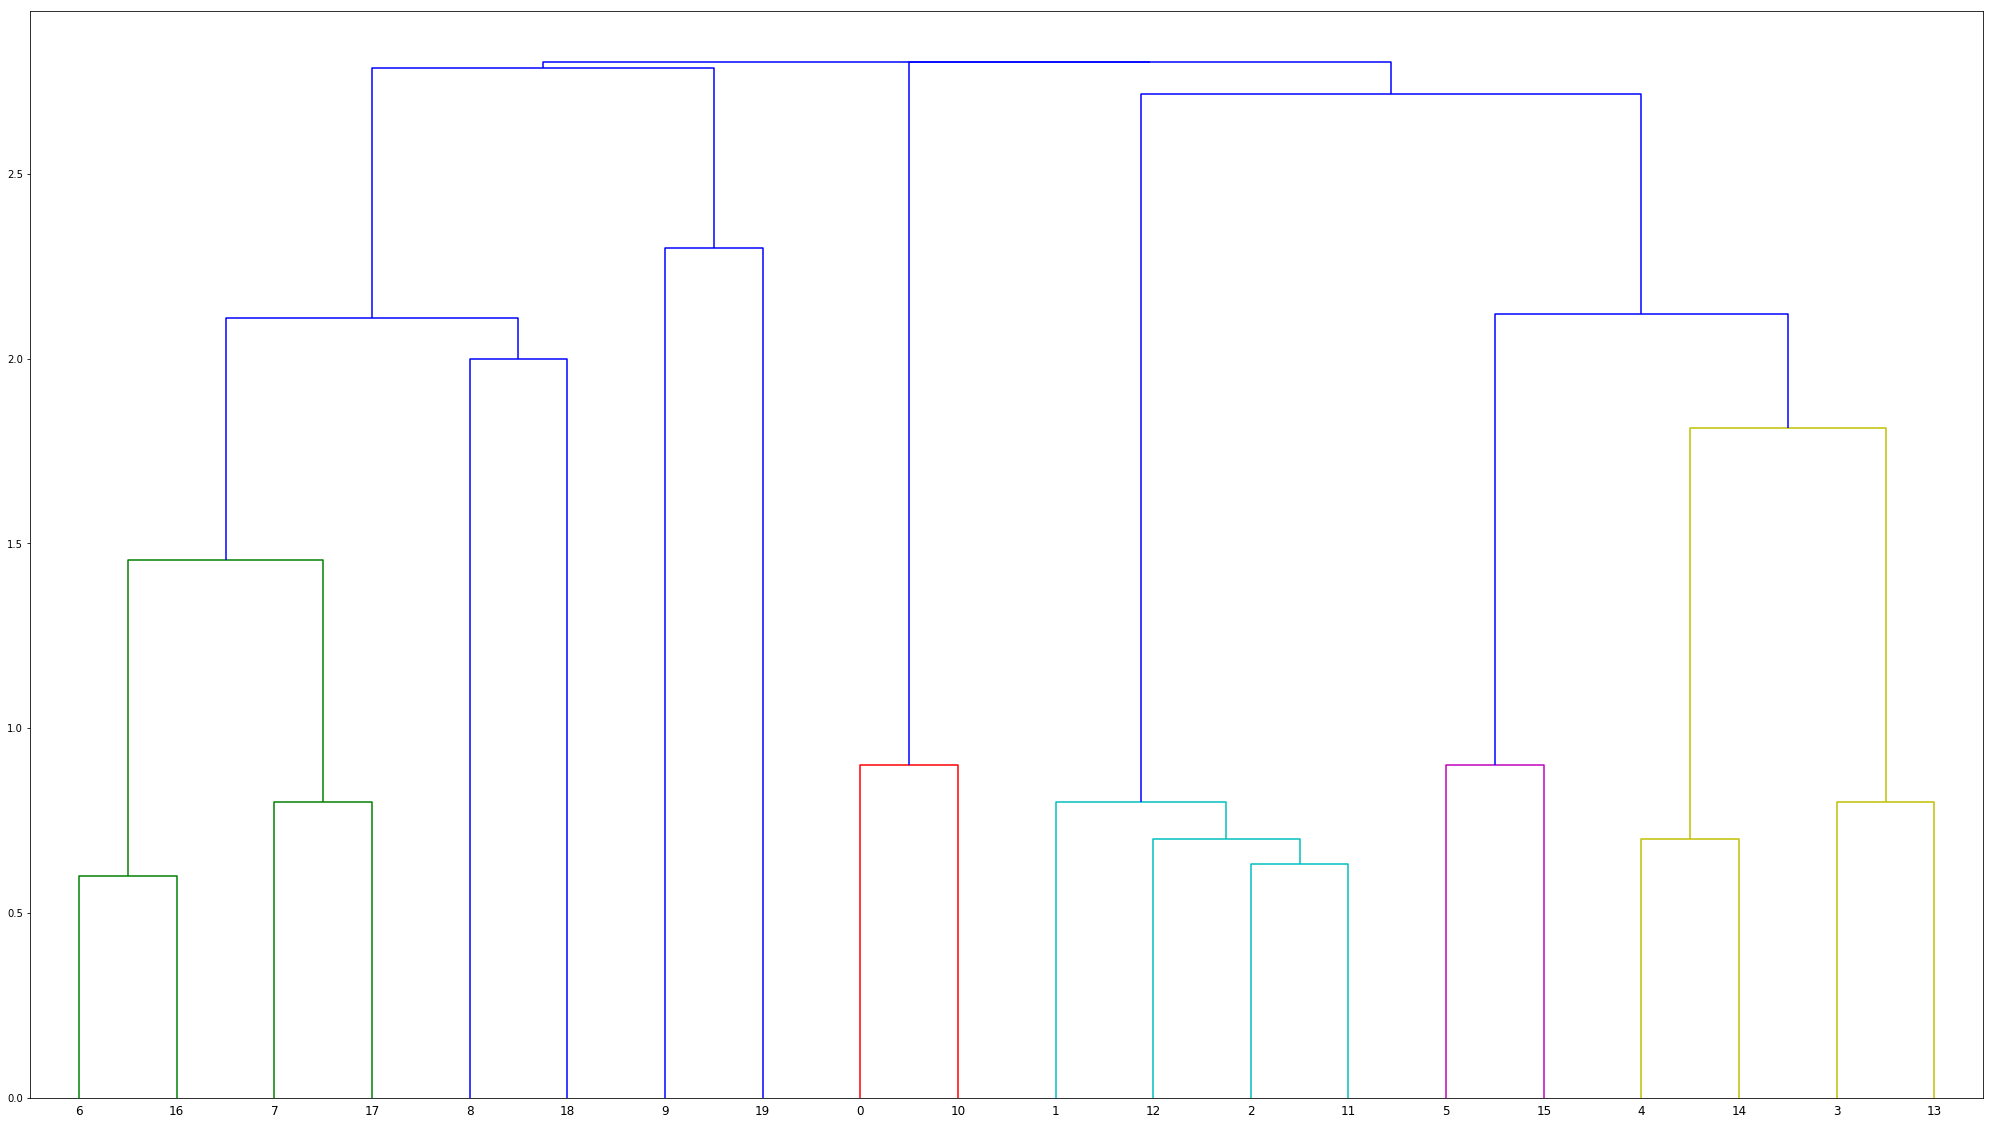

In [50]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as p
data = np.array([
    [1,2.1],  
    [2,4.9],
    [3,5.5],
    [4,8.2],
    [5,10],
    [6,12.1],
    [7,14.9],
    [8,16.3],
    [9,18.4],
    [10,21],
    [1.9,2.1],  
    [2.8,4.9],
    [3.7,5.5],
    [4.8,8.2],
    [5.7,10],
    [6.9,12.1],
    [7.6,14.9],
    [8.8,16.3],
    [11,18.4],
    [12.3,21],])
labels = range(1, 21)  
p.figure(figsize=(20, 7))  
p.subplots_adjust(bottom=0.1)  
p.scatter(data[:,0],data[:,1], label='True Position')
linkag = linkage(data, 'complete')
graph = p.figure(figsize=(35, 20))
dendro = dendrogram(linkag)
linkag = linkage(data, 'single')
graph = p.figure(figsize=(35, 20))
dendro = dendrogram(linkag)
p.show()

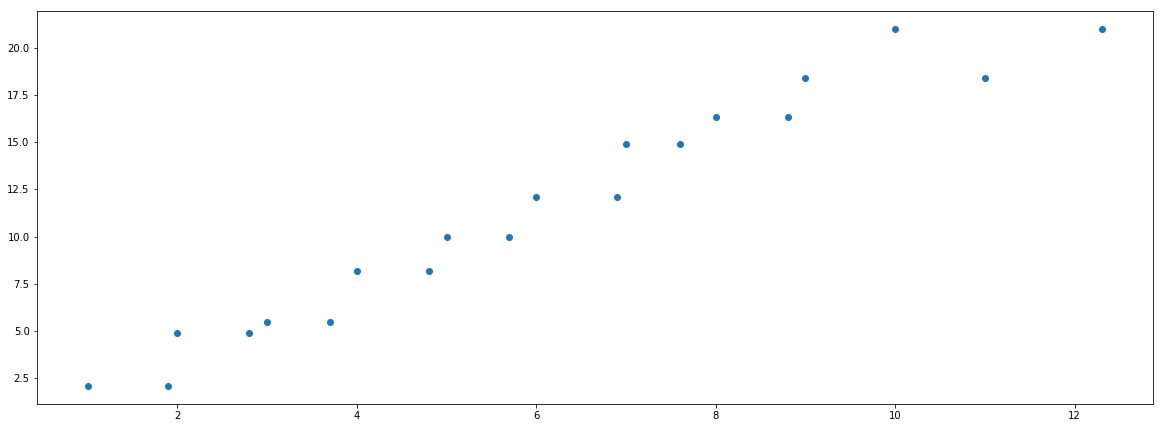

In [56]:

labels = range(1, 21)  
p.figure(figsize=(20, 7))  
p.subplots_adjust(bottom=0.1)  
p.scatter(data[:,0],data[:,1], label='True Position')

In [54]:
import numpy as np
import weakref
from collections import defaultdict
from data_reader import DataReader
from similarity import computeDistance
from time import time
import math
from pathlib import Path
import pickle
import pprint
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
import sys

# Pretty Printer Object for printing with indenting
pp = pprint.PrettyPrinter(indent = 4)

# decorator fuction for calculating runtime
def timer(func):
	def wrapper(*args):
		t = time()
		res=func(*args)
		print('Finished in', time()-t, 'sec')
		return res
	return wrapper

# Class for keeping track of Union Operations and updating the linkage matrix
class UnionTracker:
	factor = 1
	def __init__(self, points):
		'''initializer function for UnionTracker'''
		self.points = points
		assert self.points > 1, "Number of points should be greater than 0, {} was provided".format(self.points)
		self.linkage_matrix = np.zeros((self.points-1, 4))

	def union(self, A, B, dist, pts, iteration):
		'''Create a Union Entry in the linkage Matrix'''
		self.linkage_matrix[iteration][0] = A
		self.linkage_matrix[iteration][1] = B
		self.linkage_matrix[iteration][2] = dist*UnionTracker.factor
		self.linkage_matrix[iteration][3] = pts

class Cluster:
	''' Cluster class for creating and maintaining the clusters for the heirarchical clustering'''
	ClusterCount = 0
	_instances = defaultdict()
	maxClusters = 0

	def __init__(self, key=None, seq=None):
		''' Initialization of clusters '''
		self._id = Cluster.ClusterCount
		self.initID = self._id
		Cluster.ClusterCount+=1
		Cluster.maxClusters += 1
		self.clusterMembers = dict()
		self._instances[self.initID] = weakref.ref(self)
		self.factor = 1
		if key is not None:
			self.addMember(key, seq)

	def __del__(self):
		''' Destructor for the Cluster Object'''
		Cluster._instances.pop(self.initID, None)

	def incrementFactor(self, factor=1):
		''' Increment Multiplication Factor'''
		self.factor += factor

	def addMember(self, key, seq):
		''' Add memebers (data points) to the cluster, in form of dictionary where the dna sequence is the value'''
		self.clusterMembers[key] = seq

	def destroy(self):
		''' Explcit destructor call '''
		self.__del__()

	def updateID(self, iteration):
		''' Update the id of the cluster after merge operation to n+i where i is the iteration number'''
		self._id = Cluster.maxClusters + iteration

	@property
	def memberCount(self):
		'''returns the number of members in the cluster currently '''
		return len(self.clusterMembers.keys())

	@property
	def sequences(self):
		''' Returns the Member DNA sequences in the cluster '''
		return [self.clusterMembers[key] for key in self.clusterMembers.keys()]

	@classmethod
	def getClusterById(cls, clusterID):
		''' Fetch cluster object by referencing its id from the Cluster weak reference storage '''
		ref = cls._instances[clusterID]
		obj = ref()
		return obj


	@classmethod
	def generateInitialDistanceMatrix(cls, test = False):
		''' Generate the initial nxn distance matrix by computing Distance between each DNA sequence '''

		# For Testing Purpose
		if test == True:
			cls.simMatrix = np.array([[0,9,3,6,11],[9,0,7,5,10],[3,7,0,9,2],[6,5,9,0,8],[11,10,2,8,0]], dtype=float)
		# Actual Dataset Implementation
		else:
			pickleFilePath = Path('data/simMat_3.pkl')
			if pickleFilePath.exists():
				# Load Pickle File storing the simMatrix
				with open(pickleFilePath, 'rb') as file:
					cls.simMatrix = pickle.load(file)
			else:
				# Compute Distance among DNA Sequence
				cls.simMatrix = np.ones((cls.ClusterCount, cls.ClusterCount))
				for cID in range(cls.ClusterCount):
					clusterA = cls.getClusterById(cID)
					for _cID in range(cID, cls.ClusterCount):
						clusterB = cls.getClusterById(_cID)
						seq1 = clusterA.sequences[0]
						seq2 = clusterB.sequences[0]
						similarity_1 = computeDistance(seq1, seq2)
						cls.simMatrix[cID, _cID] = similarity_1
						cls.simMatrix[_cID, cID] = similarity_1
						print("similarity between {} and {} = {}\r".format(cID, _cID, similarity_1), end='', flush=True)
						sys.stdout.flush()
					print('')
				# Save The Pickle File
				with open(pickleFilePath, 'wb') as file:
					pickle.dump(cls.simMatrix, file)
			# Normalize the Matrix
			# minval = np.amin(cls.simMatrix, axis=(0,1))
			# maxval = np.amax(cls.simMatrix, axis=(0,1))
			# cls.simMatrix = ((cls.simMatrix-minval)/(maxval-minval))

	@classmethod
	def getClusters(cls):
		for key in cls._instances.keys():
			ref = cls._instances[key]
			obj = ref()
			if obj is not None:
				yield obj
			else:
				cls._instances.pop(key, None)


	@classmethod
	def currentClusterCount(cls):
		''' Returns the currently  existent clusters'''
		return len(cls._instances.keys())


	# Class method to find the minimum distance cluster pair
	@classmethod
	def findMinDistance(cls):
		''' Find the clusters most similar to each other i.e. with the least distance among them '''
		minDistance = 1*math.inf
		clusterA = None
		clusterB = None
		for rowNumber in range(0,cls.simMatrix.shape[0]-1):
			for colNumber in range(rowNumber+1, cls.simMatrix.shape[1]):
				if cls.simMatrix[rowNumber, colNumber] < minDistance:
					minDistance = cls.simMatrix[rowNumber, colNumber]
					clusterA = rowNumber
					clusterB = colNumber
		return clusterA, clusterB, minDistance

	@classmethod
	def mergeSimilarClusters(cls, mergedRC, toDelete, iteration, dist, heuristic = 'Centroid'):
		''' Cluster merging and new CLuster Creation based on the preset Heuristic 
			Available Heuristic Values are,
				- Centroid
				- Max
				- Min
		'''
		outdated_m = mergedRC
		outdated_d = toDelete
		
		delCluster = cls.getClusterById(outdated_d)
		toDelete = delCluster._id
		mergedCluster = cls.getClusterById(outdated_m)
		mergedRC = mergedCluster._id

		d_mem = delCluster.memberCount
		m_mem = mergedCluster.memberCount

		if heuristic == 'Centroid': #Compute using Centroid Calculation
			rowSum = (cls.simMatrix[outdated_m, :]*m_mem + cls.simMatrix[outdated_d, :]*d_mem)/(m_mem+d_mem)
		elif heuristic == 'Max':    #Compute using Max Calculation
			rowStack = np.vstack((cls.simMatrix[outdated_m, :], cls.simMatrix[outdated_d, :]))
			rowSum = np.amax(rowStack, axis=0)
		elif heuristic == 'Min':	#Compute using Min Calculation
			rowStack = np.vstack((cls.simMatrix[outdated_m, :], cls.simMatrix[outdated_d, :]))
			rowSum = np.amin(rowStack, axis=0)

		#Update the new row
		cls.simMatrix[:, outdated_m] = rowSum
		cls.simMatrix[outdated_m, :] = rowSum
		cls.simMatrix[:, outdated_d] = 1*math.inf
		cls.simMatrix[outdated_d, :] = 1*math.inf

		#Merge Data Points into the cluster
		for key in delCluster.clusterMembers.keys():
			mergedCluster.addMember(key, delCluster.clusterMembers[key])
		mergedCluster.updateID(iteration)
		mergedCluster.incrementFactor()
		print('Union ({} - {}), distance {}'.format(toDelete, mergedRC, dist))

		# Delete the redundant clusters explicityly
		delCluster.destroy()
		return mergedRC, toDelete, mergedCluster.memberCount, mergedCluster.factor

# Driver Function to execute the Heirarchical Clustering
@timer
def main():
	test = False
	heuristic = 'Centroid'
	reader = DataReader()
	data = reader.loadData()
	dataArray = reader.getDataArray()
	if test == True:
		clusters = [Cluster(dataPoint, data[dataPoint]) for dataPoint in list(data.keys())[:5]]		
	else:
		clusters = [Cluster(dataPoint, data[dataPoint]) for dataPoint in list(data.keys())[:]]		
	Cluster.generateInitialDistanceMatrix(test)
	Uni = UnionTracker(len(clusters))
	print('')
	iteration = 0
	while(Cluster.currentClusterCount() > 1):
		clsA, clsB, dist = Cluster.findMinDistance()
		mergedRC = min(clsA, clsB)
		toDelete = max(clsA, clsB)
		newIDm, newIDd, pts, factor = Cluster.mergeSimilarClusters(mergedRC, toDelete, iteration, dist, heuristic=heuristic)
		Uni.union(newIDd, newIDm, dist, pts, iteration)
		iteration += 1

	labels = list(data.keys())
	drawDendrogram(Uni, labels, heuristic)

def drawDendrogram(UniObj, labels, heuristic):
	''' Generate the dendrogram using te UniObject's linkage matrix '''
	plt.title("Dendrogram - Agglomerative Clustering -" + heuristic)
	dendrogram(UniObj.linkage_matrix, show_leaf_counts = True, show_contracted = True, labels = labels)
	plt.show()

if __name__ == "__main__":
	main() 

ModuleNotFoundError: No module named 'data_reader'

In [55]:
from sklearn.cluster import AgglomerativeClustering
# Affinity = {“euclidean”, “l1”, “l2”, “manhattan”,
# “cosine”}
# Linkage = {“ward”, “complete”, “average”}
Hclustering = AgglomerativeClustering(n_clusters=10,
 affinity=‘euclidean’, linkage=‘ward’)
Hclustering.fit(Cx)
ms = np.column_stack((ground_truth,Hclustering.labels_))
df = pd.DataFrame(ms,
 columns = [‘Ground truth’,’Clusters’])
pd.crosstab(df[‘Ground truth’], df[‘Clusters’],
 margins=True)

SyntaxError: invalid character in identifier (<ipython-input-55-2abf858b42f4>, line 6)

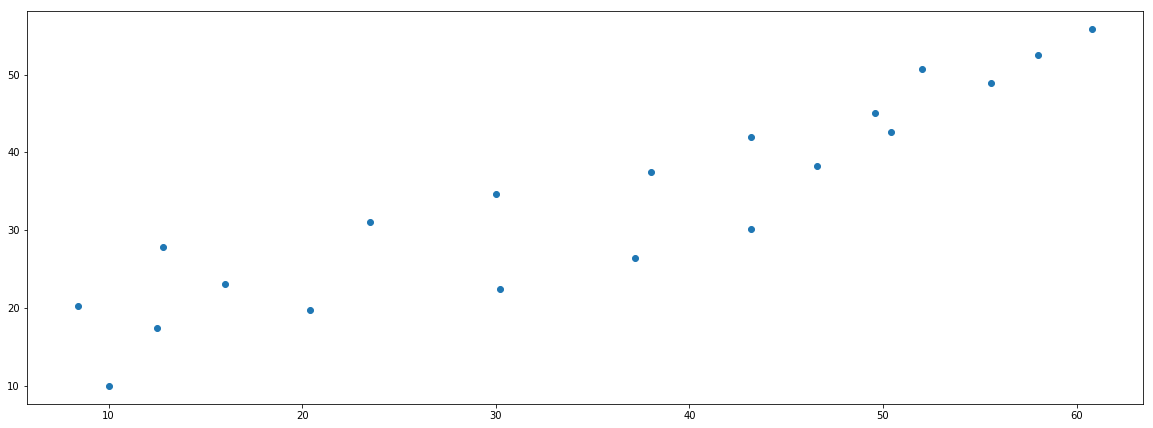

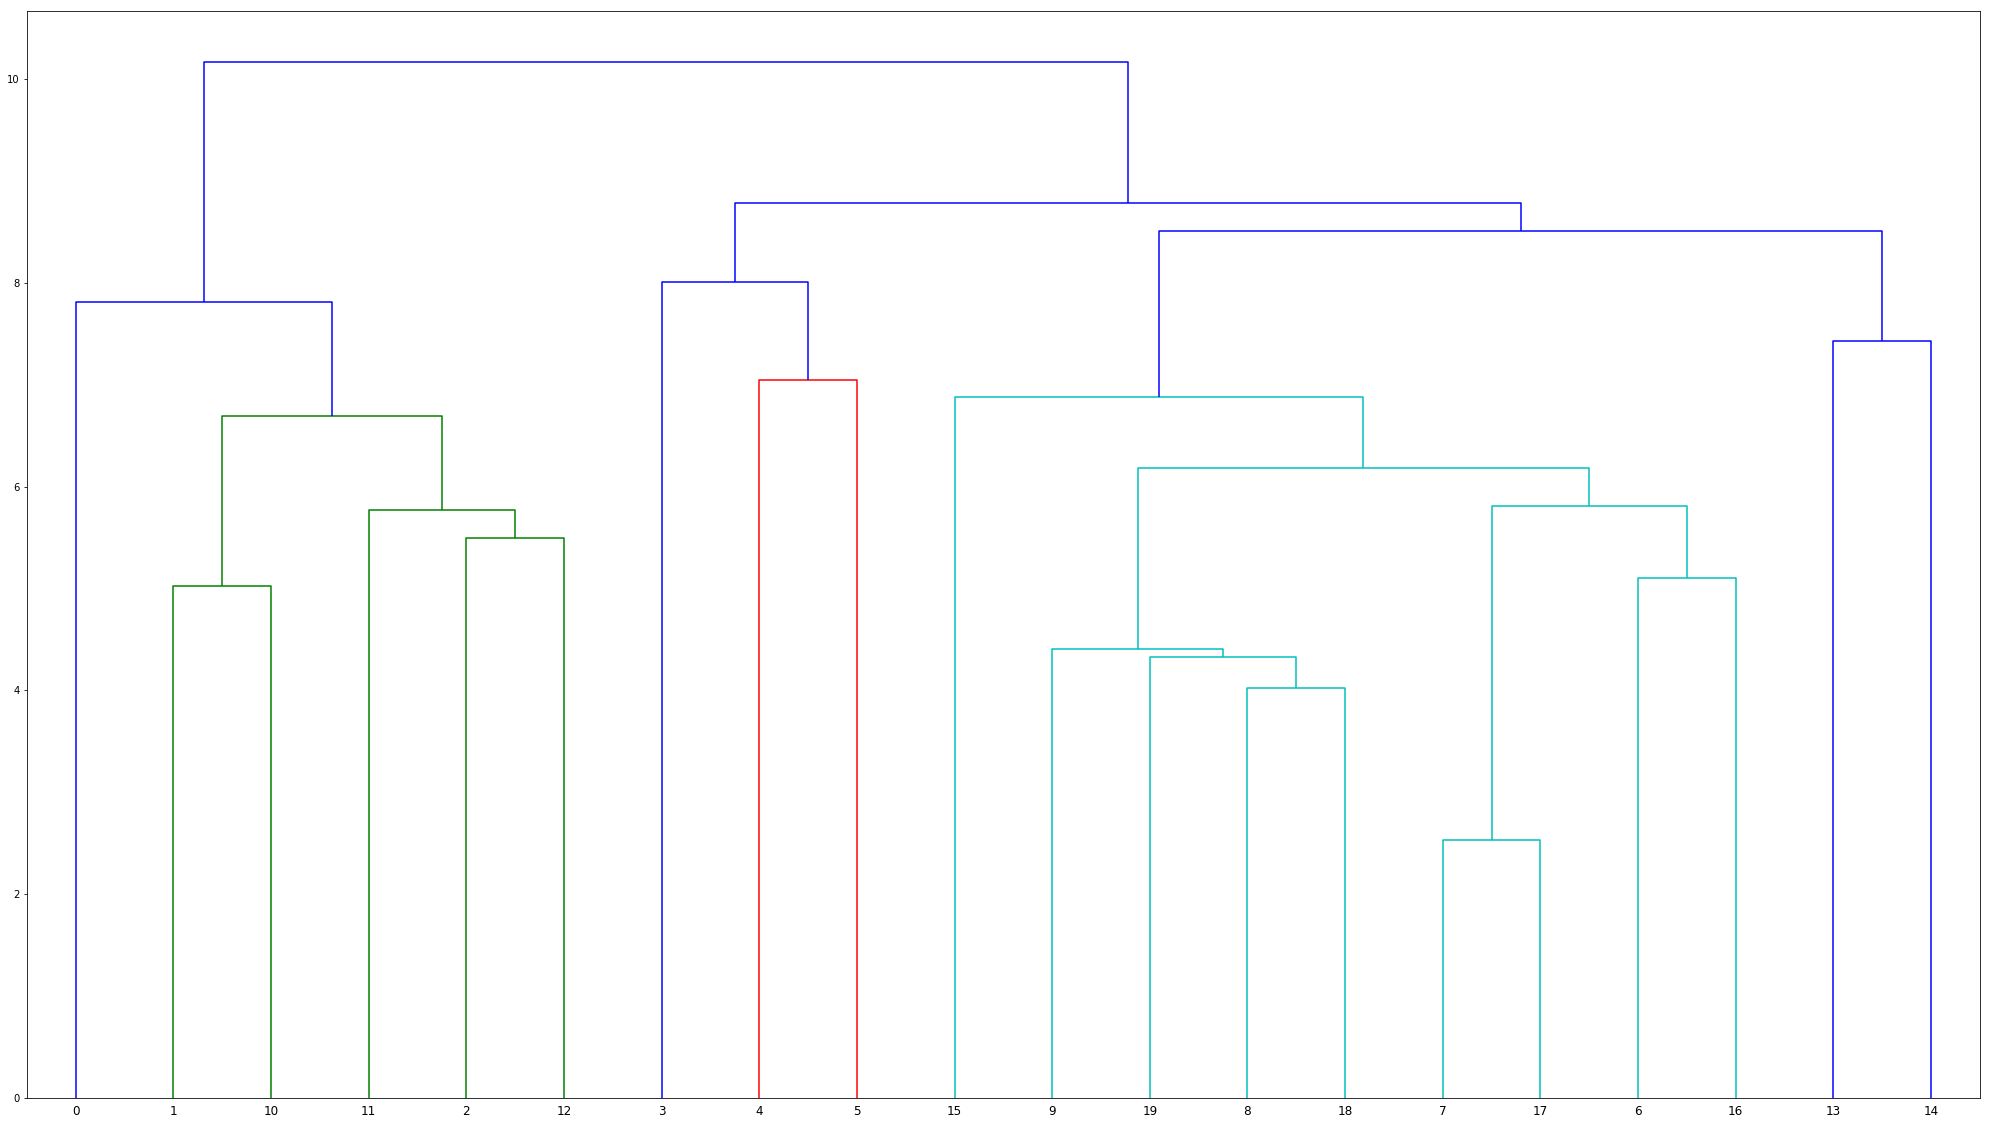

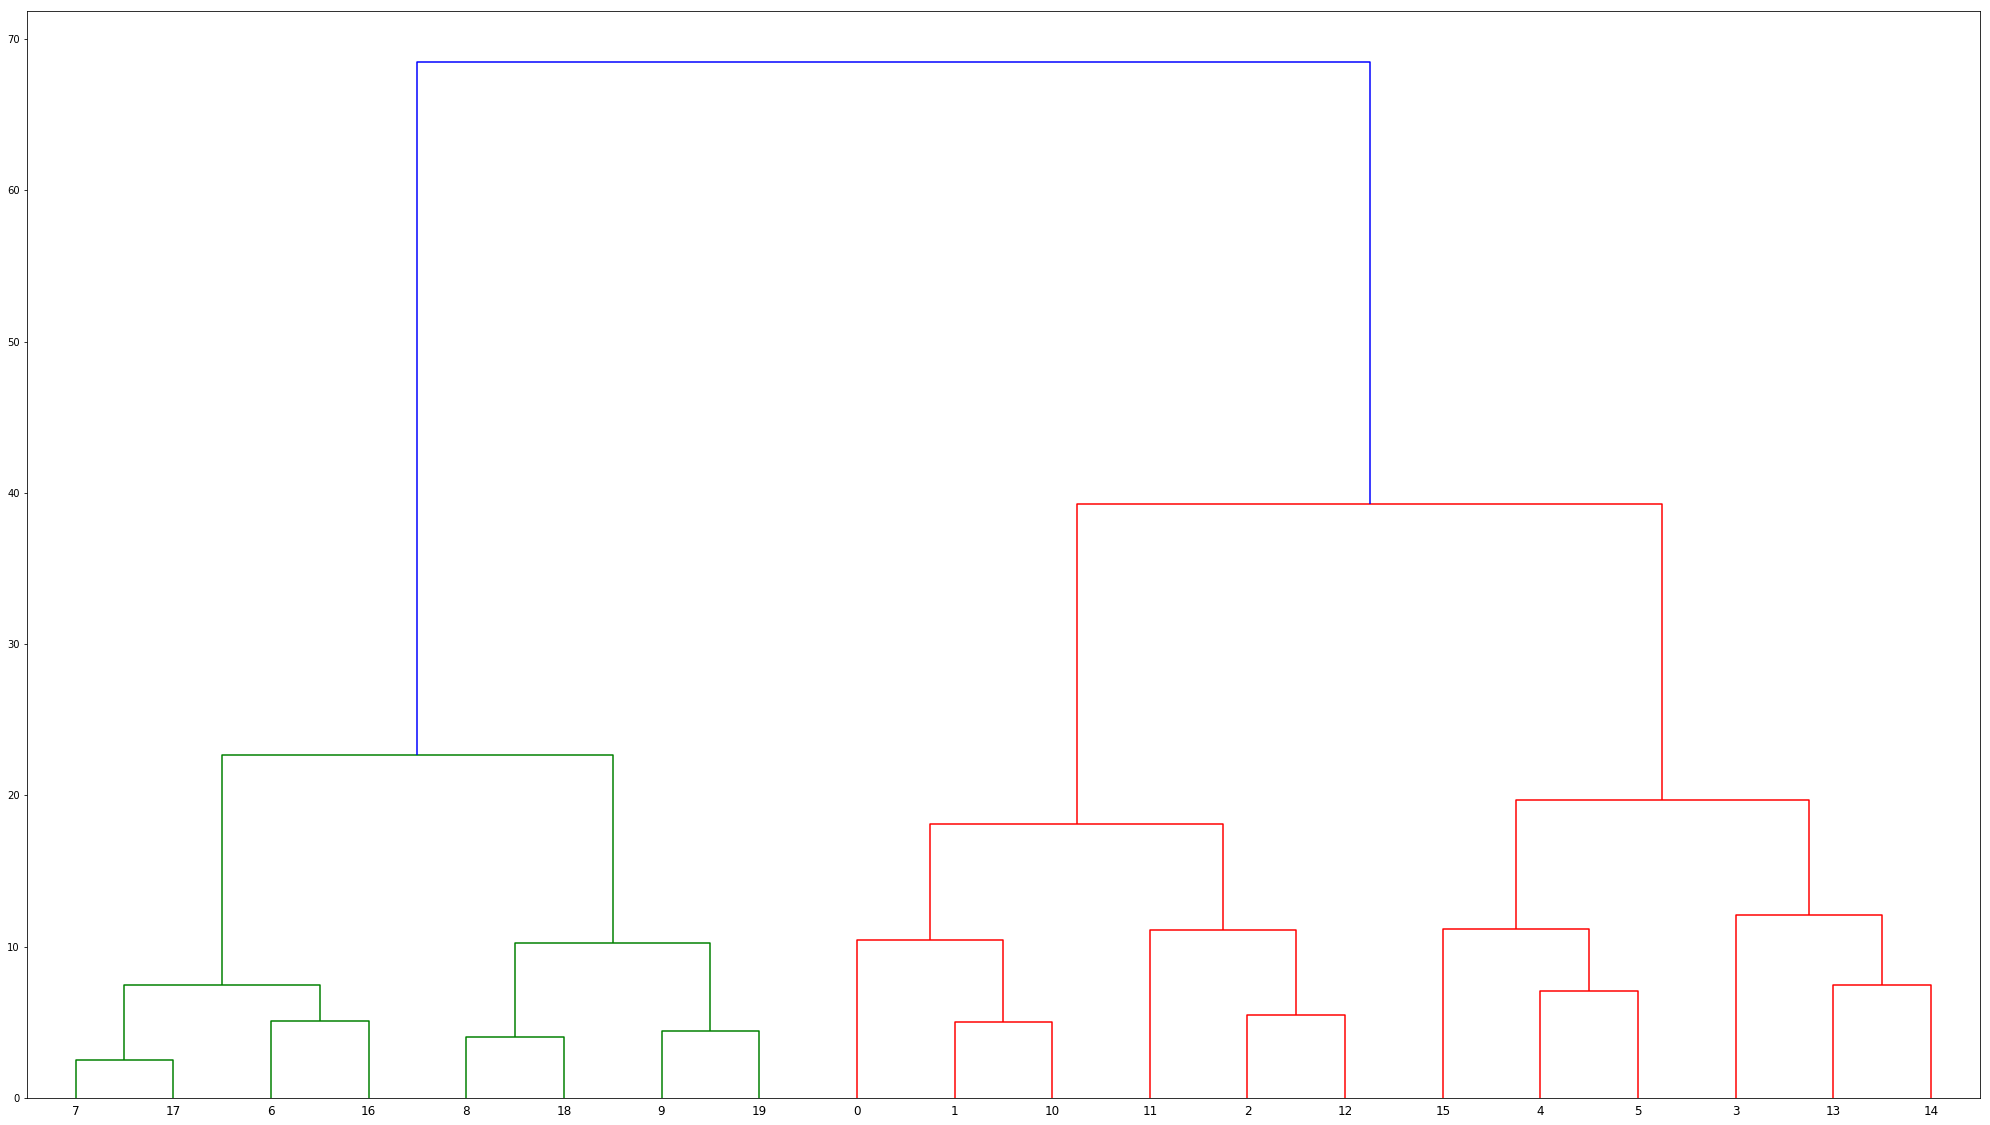

In [61]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as pt

values = np.array([[10,10],
            [12.5,17.4],
            [20.4,19.8],
            [30.2,22.5],
            [37.2,26.4],
            [43.2,30.1],
            [46.6,38.2],
            [50.4,42.6],
            [55.6,48.9],
            [60.8,55.9],
            [8.4, 20.3],      
            [12.8,27.9],
            [16,23.1],
            [23.5,31],
            [30,34.6],
            [38,37.5],
            [43.2,42],
            [49.6,45],
            [52,50.7],
            [58,52.5],])
labels = range(1, 21)  
pt.figure(figsize=(20, 7))  
pt.subplots_adjust(bottom=0.1)  
p.scatter(values[:,0],values[:,1], label='True Position')
linkag = linkage(values, 'single')
graph = pt.figure(figsize=(35, 20))
dendro = dendrogram(linkag)
pt.show()
linkag = linkage(values, 'complete')
graph = pt.figure(figsize=(35, 20))
dendro = dendrogram(linkag)